In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from analysis_helpers import *

In [2]:
df_original = pd.read_parquet('../data/used_cars_training_data_07_24.parquet')
df_new = pd.read_parquet('../data/used_cars_training_data.parquet')

df = df_original.replace('', np.nan)

# Drop high nans
new_nan_mean = df.isna().mean()
high_nans = new_nan_mean[new_nan_mean > 0.5].keys()
print('High nans', high_nans)
df.drop(columns=high_nans, inplace=True, errors='ignore')

# Mainly 1 value
categorical_features = df.select_dtypes(include=['object']).columns
extramely_low_cardinlity = []
print('Extramely low cardinality')
for col in categorical_features:
    vals = df[col].dropna().value_counts()
    ratios = vals/vals.sum()
    if ratios[0] > 0.9:
        print(col, ratios[0])
        extramely_low_cardinlity.append(col)

df.drop(columns=extramely_low_cardinlity, inplace=True, errors='ignore')

cols = df.columns

numeric_features = df.select_dtypes(include=['float','int']).columns
tfid_features = list(cols[cols.str.contains('tfid')])
numeric_features = [x for x in numeric_features if x not in tfid_features + ['word_count']]

binary_features = df.select_dtypes(include=['bool']).columns
categorical_features = list(df.select_dtypes(include=['object']).columns)

non_categorical_features = list(numeric_features) + list(binary_features)
df[non_categorical_features] = df[non_categorical_features].astype(float)

df.head()

High nans Index(['roof', 'term', 'winter tires construction type',
       'back summer tires construction type',
       'back winter tires construction type'],
      dtype='object')
Extramely low cardinality
cylinder arrangement 0.9118207816968541
nature of documents 0.9261494431655571
summer tires construction type 1.0


price (HUF)  condition  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/volkswa...    6895000.0     Kitűnő   
https://www.hasznaltauto.hu/szemelyauto/mercede...    9999999.0  Megkímélt   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...    4995000.0     Kitűnő   
https://www.hasznaltauto.hu/szemelyauto/renault...    3499000.0     Kitűnő   
https://www.hasznaltauto.hu/szemelyauto/mercede...    7990000.0     Normál   

                                                                          design  \
link                                                                               
https://www.hasznaltauto.hu/szemelyauto/volkswa...                         Sedan   
https://www.hasznaltauto.hu/szemelyauto/mercede...  Városi terepjáró (crossover)   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...  Városi terepjáró (crossover)   
https://www.hasznaltauto.hu/szemelyauto/renault...  Városi terepjáró (crossover)   
https://www.hasznaltauto.hu/szemelyauto/mercede...  Városi terepjáró (crossover)   

                                                    financing  \
link                                                            
https://www.hasznaltauto.hu/szemelyauto/volkswa...       25.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...       20.0   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...       20.0   
https://www.hasznaltauto.hu/szemelyauto/renault...      100.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...       20.0   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/volkswa...             110000.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...             119300.0   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...              70000.0   
https://www.hasznaltauto.hu/szemelyauto/renault...             100000.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...              74760.0   

                                                    shippable persons number  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/volkswa...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/renault...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...                       5.0   

                                                    number of doors     color  \
link                                                                            
https://www.hasznaltauto.hu/szemelyauto/volkswa...              4.0    fekete   
https://www.hasznaltauto.hu/szemelyauto/mercede...              5.0     fehér   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...              5.0       kék   
https://www.hasznaltauto.hu/szemelyauto/renault...              5.0  sötétkék   
https://www.hasznaltauto.hu/szemelyauto/mercede...              5.0     fehér   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/volkswa...           1426.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...           2150.0   
https://www.hasznaltauto.hu/szemelyauto/dacia/d...           1200.0   
https://www.hasznaltauto.hu/szemelyauto/renault...           1176.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...           1470.0   

                                                    total weight (kg)  ...  \
link                                                                   ...   
https://www.hasznaltauto.hu/szemelyauto/volkswa...             2040.0  ...   
https://www.hasznaltauto.hu/szemelyauto/mercede...             2950.0  ..

In [3]:
len(df_original)

32156

In [4]:
df_new = df_new[~df_new.index.isin(df_original.index)]
df_new.head()

price (HUF)  condition  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/mercede...     15890000     Normál   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...       480000     Normál   
https://www.hasznaltauto.hu/szemelyauto/toyota/...       499000     Normál   
https://www.hasznaltauto.hu/szemelyauto/opel/as...       550000     Normál   
https://www.hasznaltauto.hu/szemelyauto/toyota/...       700000  Megkímélt   

                                                                          design  \
link                                                                               
https://www.hasznaltauto.hu/szemelyauto/mercede...  Városi terepjáró (crossover)   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...                         Sedan   
https://www.hasznaltauto.hu/szemelyauto/toyota/...                         Sedan   
https://www.hasznaltauto.hu/szemelyauto/opel/as...                         Sedan   
https://www.hasznaltauto.hu/szemelyauto/toyota/...                     Ferdehátú   

                                                    financing  \
link                                                            
https://www.hasznaltauto.hu/szemelyauto/mercede...         20   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...        100   
https://www.hasznaltauto.hu/szemelyauto/toyota/...        100   
https://www.hasznaltauto.hu/szemelyauto/opel/as...        100   
https://www.hasznaltauto.hu/szemelyauto/toyota/...        100   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/mercede...                49650   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...               138187   
https://www.hasznaltauto.hu/szemelyauto/toyota/...               231510   
https://www.hasznaltauto.hu/szemelyauto/opel/as...               214000   
https://www.hasznaltauto.hu/szemelyauto/toyota/...               113988   

                                                    shippable persons number  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/mercede...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/toyota/...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/opel/as...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/toyota/...                       5.0   

                                                    number of doors     color  \
link                                                                            
https://www.hasznaltauto.hu/szemelyauto/mercede...              5.0    szürke   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...              4.0       kék   
https://www.hasznaltauto.hu/szemelyauto/toyota/...              4.0     fehér   
https://www.hasznaltauto.hu/szemelyauto/opel/as...              5.0       kék   
https://www.hasznaltauto.hu/szemelyauto/toyota/...              5.0  olajzöld   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/mercede...           1680.0   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...           1010.0   
https://www.hasznaltauto.hu/szemelyauto/toyota/...           1060.0   
https://www.hasznaltauto.hu/szemelyauto/opel/as...           1205.0   
https://www.hasznaltauto.hu/szemelyauto/toyota/...            915.0   

                                                    total weight (kg)  ...  \
link                                                                   ...   
https://www.hasznaltauto.hu/szemelyauto/mercede...             2195.0  ...   
https://www.hasznaltauto.hu/szemelyauto/daewoo/...             1500.0  ..

In [5]:
target = 'price (HUF)'

features_with_outliers = []
for col in numeric_features:
    if has_outliers(df, col, multiplier=7):
        print('Handel ouliers at', col)
        df = cap_values(df, col, multiplier=7)
        features_with_outliers.append(col)


Handel ouliers at clock position (km)
Handel ouliers at shippable persons number
Handel ouliers at total weight (kg)
Handel ouliers at trunk (l)
Handel ouliers at cylinder capacity (cm3)
Handel ouliers at power (kW)


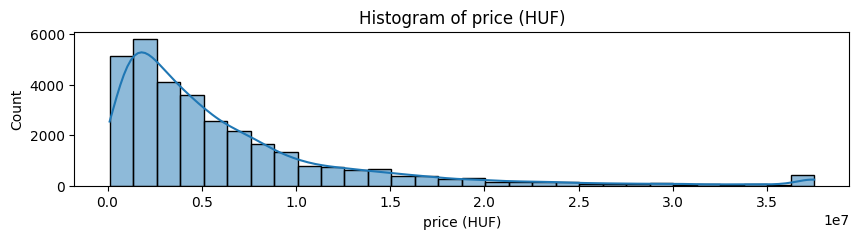

In [6]:
plt.figure(figsize=(10, 2))
sns.histplot(data=df, x=target, bins=30, kde=True)
plt.title(f'Histogram of {target}')
plt.show()

In [7]:
target_log = 'price log'
df[target_log] = np.log10(df[target])

/var/folders/6p/rn1y8jlj4q5fp4y6jrn3qslc0000gn/T/ipykernel_18024/361931131.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[target_log] = np.log10(df[target])


In [8]:
"""
df_tmp = df.copy()
df_tmp.reset_index(drop=True, inplace=True)
df_tmp.drop(columns=target, inplace=True)
df_tmp.to_parquet('../data/train_for_log_price.parquet')#"""

"\ndf_tmp = df.copy()\ndf_tmp.reset_index(drop=True, inplace=True)\ndf_tmp.drop(columns=target, inplace=True)\ndf_tmp.to_parquet('../data/train_for_log_price.parquet')#"

In [9]:
def replace_less_frequent(ser, count_limit, max_feature_number):
    # Calculate value counts
    counts = ser.value_counts()

    # Select top "max_feature_number" most frequent values
    top_values = counts.nlargest(max_feature_number).index

    # Select values which have count less than "count_limit"
    less_freq_values = counts[counts < count_limit].index

    # Values to replace: not in top values or less than "count_limit"
    to_replace = less_freq_values.union(counts.index.difference(top_values))
    
    if len(to_replace) == 0:
        return ser
    
    # Replace these values with "Other"
    ser_replaced = ser.replace(to_replace, "Other")

    # Recalculate value counts
    new_counts = ser_replaced.value_counts()

    # If "Other" count still doesn't reach "count_limit", replace least frequent values
    while new_counts["Other"] < count_limit:
        least_frequent_value = new_counts[new_counts.index != "Other"].nsmallest(1).index[0]
        ser_replaced = ser_replaced.replace(least_frequent_value, "Other")
        new_counts = ser_replaced.value_counts()

    return ser_replaced

def one_hot_encode(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    for column in categorical_columns:
        dummies = pd.get_dummies(df[column], dummy_na=False, prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)

    return df

# Handle catagroical values that less frequnt 
for col in categorical_features:
    if col == 'city':
        df[col] = replace_less_frequent(df[col], 500, 10)
    else:
        df[col] = replace_less_frequent(df[col], 1000, 10)

In [10]:
df_transformed = one_hot_encode(df)

In [12]:
df_transformed.isna().sum()

price (HUF)                   0
financing                     0
clock position (km)           0
shippable persons number    790
number of doors             787
                           ... 
city_győr                     0
city_kecskemét                0
city_nyíregyháza              0
city_pécs                     0
city_székesfehérvár           0
Length: 348, dtype: int64

In [40]:
def get_train_test(df):
    categorical_features = list(df.select_dtypes(include=['object']).columns)
    X = df.drop(columns=[target, target_log]).copy()
    if categorical_features:
        X[categorical_features] = X[categorical_features].fillna('missing')
    y = df[target_log]

    return train_test_split(X, y, test_size=0.2, random_state=0)


In [41]:
X_train, X_test, y_train, y_test = get_train_test(df)


In [78]:
from catboost import CatBoostRegressor

def regression_train(X_train, X_test, y_train, y_test, categorical_features,
                     iterations=15000,learning_rate=None, l2_leaf_reg=10, depth=5):
    model = CatBoostRegressor(
        loss_function='MAE',
        depth=4,
        iterations=iterations,
        l2_leaf_reg=10,
        learning_rate=learning_rate,
        cat_features=categorical_features,
        #subsample=0.5, rsm=0.2,
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        verbose=1000  # output the result every 100 iterations
    )
    
    return model

In [79]:
model = regression_train(X_train, X_test, y_train, y_test, categorical_features)

0:	learn: 0.3568461	test: 0.3566303	best: 0.3566303 (0)	total: 11.5ms	remaining: 2m 51s
1000:	learn: 0.0685230	test: 0.0726629	best: 0.0726629 (1000)	total: 10.9s	remaining: 2m 32s
2000:	learn: 0.0635440	test: 0.0696575	best: 0.0696575 (2000)	total: 21.9s	remaining: 2m 22s
3000:	learn: 0.0605306	test: 0.0682258	best: 0.0682256 (2998)	total: 32.7s	remaining: 2m 10s
4000:	learn: 0.0583580	test: 0.0673921	best: 0.0673920 (3999)	total: 43.6s	remaining: 1m 59s
5000:	learn: 0.0566091	test: 0.0668439	best: 0.0668428 (4997)	total: 54.5s	remaining: 1m 48s
6000:	learn: 0.0551616	test: 0.0664387	best: 0.0664387 (6000)	total: 1m 5s	remaining: 1m 37s
7000:	learn: 0.0538794	test: 0.0661014	best: 0.0661013 (6999)	total: 1m 16s	remaining: 1m 26s
8000:	learn: 0.0527227	test: 0.0658220	best: 0.0658220 (8000)	total: 1m 26s	remaining: 1m 15s
9000:	learn: 0.0517227	test: 0.0655996	best: 0.0655986 (8998)	total: 1m 37s	remaining: 1m 5s
10000:	learn: 0.0507819	test: 0.0654000	best: 0.0654000 (9996)	total: 1m 

In [80]:
def test_model(model, X_train, X_test, y_train, y_test):
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)

    print("Train R2: ", metrics.r2_score(y_train, train_predictions))
    print("Test R2: ", metrics.r2_score(y_test, test_predictions))
    print("Train MAPE: ", metrics.mean_absolute_percentage_error(10**y_train, 10**train_predictions))
    print("Test MAPE: ", metrics.mean_absolute_percentage_error(10**y_test, 10**test_predictions))


In [81]:
test_model(model, X_train, X_test, y_train, y_test)

Train R2:  0.9692782989474114
Test R2:  0.9546147133678339
Train MAPE:  0.11440454455159314
Test MAPE:  0.1553191573681351


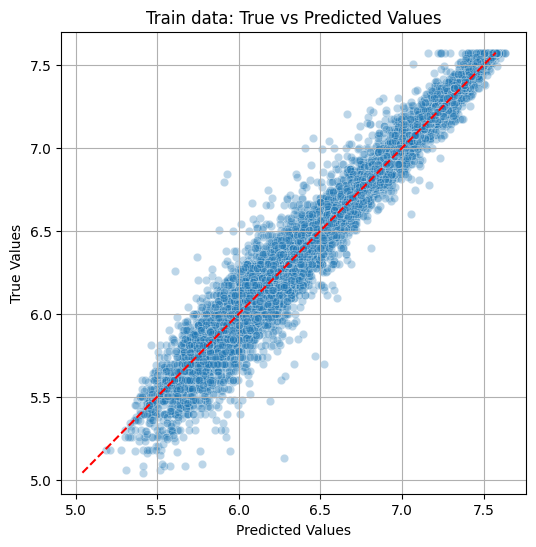

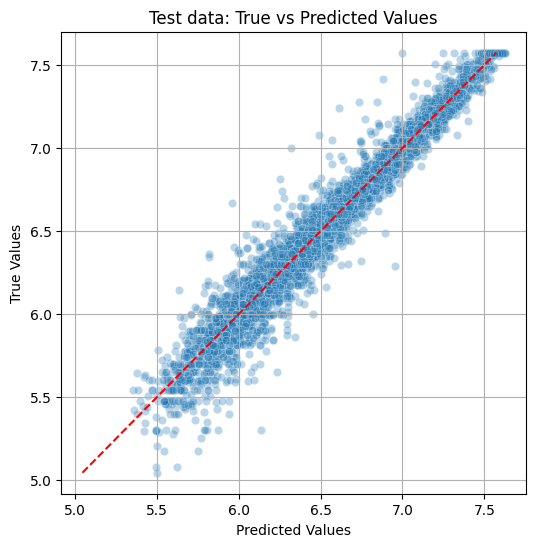

In [82]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_pred, y=y_true, alpha=0.3)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Generate predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the results
plot_predictions(y_train, y_train_pred, 'Train data: True vs Predicted Values')
plot_predictions(y_test, y_test_pred, 'Test data: True vs Predicted Values')

In [88]:
features = df.columns.drop([target, target_log])
X = df[features].copy()
X

In [89]:
# Generate predictions
y_pred = 10**model.predict(X)

In [90]:
difference = y_pred - df[target].values

In [91]:
df2 = df.copy()
df2['difference'] = difference

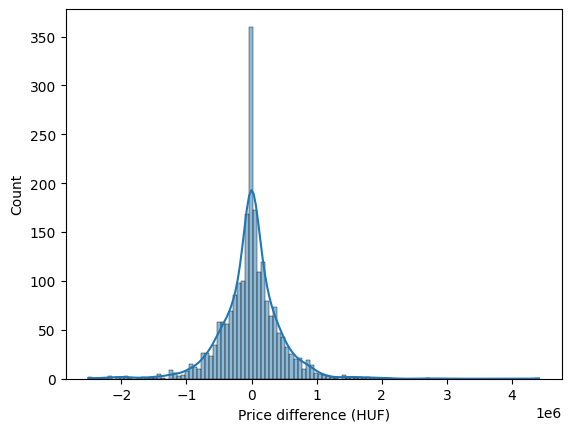

In [141]:
price_range = (df['price (HUF)'] > 3e6) & (df['price (HUF)'] < 3.75e6)

sns.histplot(x=difference[price_range], kde=True)
#sns.histplot(x=difference, kde=True)
plt.xlabel('Price difference (HUF)')
#plt.xlim(-5e6, 5e6)
plt.show()

In [142]:
df[price_range]['age (year)'].median()

10.0

In [143]:
df[price_range]['age (year)'].mean()

10.52749301025163

In [144]:
df_select = df2[price_range].sort_values('difference', ascending=False).head()

In [ ]:
import requests
from bs4 import BeautifulSoup
import ast
import re

def scrape_car_data(link):
    try:
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')

        header = soup.find_all('div', {'class':'data-relay-banner'})
        
        if len(header) == 0:
            return None, None
        
        header = ast.literal_eval(header[0]['data-vehicle-information-banner-parameters'])
        advertisement_data =  soup.find_all('table', {'class':'hirdetesadatok'})
        # Get the text from xml
        advertisement_data = advertisement_data[0].get_text(separator='#')

        # Clean it
        advertisement_data = advertisement_data.strip()
        advertisement_data = re.sub(r'#\n', '', advertisement_data)

        # Get lines
        advertisement_data = advertisement_data.split('#')

        # Clean lines and create pairs
        advertisement_data = pd.Series(advertisement_data)

        # Add header to advertisment data
        advertisement_data.update(header)

        keys_id = advertisement_data.str.contains(':$')
        values_id = np.where(keys_id)[0] + 1
        keys = advertisement_data[keys_id]
        values = advertisement_data[values_id]
        advertisement_data = dict(zip(keys, values))


        # Get equipment info
        equipments = soup.find_all('div', {'class':'row felszereltseg'})
        if equipments:
            equipments = equipments[0].text.split('\n')

        # Get other info
        other = soup.find_all('div', {'class':'egyebinformacio'})
        if other:
            other = other[0].text.split('\n')
        
        # Get description 
        description = soup.find_all('div', {'class':'leiras'})
        if description:
            description = [description[0].text]        


        # Get oll special info about the car and clean it
        special_car_info = equipments + other + description
        if special_car_info:
            special_car_info = pd.Series(special_car_info)
            special_car_info = special_car_info.str.strip()
            special_car_info = special_car_info.str.lower()
            special_car_info = special_car_info.dropna()
            special_car_info = special_car_info[~special_car_info.isin(['', '-'])]

        return advertisement_data, special_car_info
    except Exception as e:
        print(e)
        return None, None

In [224]:
missing_car = [scrape_car_data(x)[0] is None for x in df_select.index]

In [225]:
df_select[~np.array(missing_car)]

price (HUF)  condition  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/mercede...    3699000.0  Megkímélt   
https://www.hasznaltauto.hu/szemelyauto/mercede...    3500000.0    Újszerű   

                                                                          design  \
link                                                                               
https://www.hasznaltauto.hu/szemelyauto/mercede...  Városi terepjáró (crossover)   
https://www.hasznaltauto.hu/szemelyauto/mercede...                         Coupe   

                                                    financing  \
link                                                            
https://www.hasznaltauto.hu/szemelyauto/mercede...       40.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...      100.0   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/mercede...             150236.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...             204128.0   

                                                    shippable persons number  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/mercede...                       5.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...                       4.0   

                                                    number of doors  color  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/mercede...              5.0  Other   
https://www.hasznaltauto.hu/szemelyauto/mercede...              5.0  Other   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/mercede...           2315.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...           1900.0   

                                                    total weight (kg)  ...  \
link                                                                   ...   
https://www.hasznaltauto.hu/szemelyauto/mercede...             2950.0  ...   
https://www.hasznaltauto.hu/szemelyauto/mercede...             2300.0  ...   

                                                    tfidf_buys tfidf_end  \
link                                                                       
https://www.hasznaltauto.hu/szemelyauto/mercede...         0.0       0.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...         0.0       0.0   

                                                   tfidf_condition  \
link                                                                 
https://www.hasznaltauto.hu/szemelyauto/mercede...        0.087193   
https://www.hasznaltauto.hu/szemelyauto/mercede...        0.000000   

                                                    tfidf_adjustable  \
link                                                                   
https://www.hasznaltauto.hu/szemelyauto/mercede...               0.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...               0.0   

                                                    tfidf_price tfidf_inquire  \
link                                                                            
https://www.hasznaltauto.hu/szemelyauto/mercede...     0.000000           0.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...     0.704844           0.0   

                                                   tfidf_administration  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/mercede...                  0.0   
https://www.hasznaltauto.hu/szemelyauto/mercede...                  0.0   

                                                    tfidf_seat  price log  \
link                          

# New model

In [ ]:
top_features = list(df_feature_importance.head(50)['feature'])

NameError: name 'df_feature_importance' is not defined

In [227]:
df_transformed = df[top_features+[target, target_log]].copy()
df_transformed = one_hot_encode(df_transformed)

In [228]:
X_train2, X_test2, y_train2, y_test2 = get_train_test(df_transformed)


In [247]:
model2 = regression_train(X_train2, X_test2, y_train2, y_test2, None, 50000, learning_rate=None, depth=5)

0:	learn: 0.3563526	test: 0.3560859	best: 0.3560859 (0)	total: 5.5ms	remaining: 4m 34s
1000:	learn: 0.0643628	test: 0.0695505	best: 0.0695505 (1000)	total: 3.51s	remaining: 2m 51s
2000:	learn: 0.0586008	test: 0.0667762	best: 0.0667748 (1997)	total: 6.93s	remaining: 2m 46s
3000:	learn: 0.0553826	test: 0.0657522	best: 0.0657512 (2993)	total: 10.3s	remaining: 2m 42s
4000:	learn: 0.0531663	test: 0.0652023	best: 0.0652001 (3998)	total: 13.8s	remaining: 2m 38s
5000:	learn: 0.0514866	test: 0.0648669	best: 0.0648652 (4982)	total: 17.2s	remaining: 2m 34s
6000:	learn: 0.0501780	test: 0.0646680	best: 0.0646665 (5993)	total: 20.8s	remaining: 2m 32s
7000:	learn: 0.0491087	test: 0.0644827	best: 0.0644825 (6999)	total: 24.5s	remaining: 2m 30s
8000:	learn: 0.0481603	test: 0.0643173	best: 0.0643167 (7996)	total: 28.1s	remaining: 2m 27s
9000:	learn: 0.0473918	test: 0.0642000	best: 0.0641987 (8999)	total: 31.8s	remaining: 2m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0641565

In [245]:
df_feature_importance2 = feature_importances_catboost(model2)
df_feature_importance2

feature  importance
0                      age (year)   43.412437
1                      power (kW)   18.736212
2             clock position (km)    6.845707
65  gearbox_Manuális (5 fokozatú)    3.938355
3         cylinder capacity (cm3)    3.707326
..                            ...         ...
62  gearbox_Automata (7 fokozatú)    0.005938
91                   color_szürke    0.005524
80          type of climate_Other    0.005346
92              color_sötétszürke    0.004460
90                    color_piros    0.003135

[93 rows x 2 columns]

In [246]:
test_model(model2, X_train2, X_test2, y_train2, y_test2)

Train R2:  0.9652885205308892
Test R2:  0.9543576995115244
Train MAPE:  0.1311017049583491
Test MAPE:  0.15656881587221894


In [258]:
from sklearn.preprocessing import MinMaxScaler

def scale_features(X_train, X_test):
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the training data
    X_train_scaled = scaler.fit_transform(X_train.fillna(X_train.median()))

    # Transform the test data
    X_test_scaled = scaler.transform(X_test.fillna(X_train.median()))

    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scale_features(X_train2, X_test2)

In [280]:
from sklearn.neighbors import KNeighborsRegressor

def knn_regression_train(X_train, X_test, y_train, y_test, n_neighbors=5):
    # Initialize the model with the specified number of neighbors
    model = KNeighborsRegressor(n_neighbors=n_neighbors,  n_jobs=-1)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    test_model(model, X_train, X_test, y_train, y_test)
    
    return model

In [281]:
model_knn = knn_regression_train(X_train_scaled, X_test_scaled, y_train, y_test, n_neighbors=20)

Train R2:  0.828036550026409
Test R2:  0.8049355492570719
Train MAPE:  0.31547935595873444
Test MAPE:  0.33390598748196937


In [ ]:
test_model(model_knn, X_train2, X_test2, y_train2, y_test2)

In [232]:
top_transformed_features = list(df_feature_importance2.head(50)['feature'])
X_train3, X_test3, y_train3, y_test3 = get_train_test(df_transformed[top_transformed_features + [target, target_log]])


In [233]:
model3 = regression_train(X_train3, X_test3, y_train3, y_test3, None, iterations=20000)

0:	learn: 0.3563328	test: 0.3559495	best: 0.3559495 (0)	total: 4.4ms	remaining: 1m 27s
1000:	learn: 0.0650548	test: 0.0698197	best: 0.0698197 (1000)	total: 3.41s	remaining: 1m 4s
2000:	learn: 0.0597877	test: 0.0672116	best: 0.0672106 (1995)	total: 6.62s	remaining: 59.5s


KeyboardInterrupt: 

In [207]:
test_model(model3, X_train3, X_test3, y_train3, y_test3)

Train R2:  0.9701595588603656
Test R2:  0.9536927490344596
Train MAPE:  0.11881374712215347
Test MAPE:  0.15692626021450862


In [ ]:
import catboost
import shap
import matplotlib.pyplot as plt

# Create a Pool object from your test data
test_pool = catboost.Pool(data=X_test, label=y_test)  # replace y_test with your target variable for the test set if necessary

# Get the SHAP values for the validation dataset
shap_values = model.get_feature_importance(data=test_pool, type='ShapValues')

# Note: The last column of shap_values is the expected value (base value) for the model
# So, exclude it when visualizing specific instances or features.
shap_values = shap_values[:,:-1]

# Plot summary plot using SHAP library
shap.summary_plot(shap_values, test_pool)

plt.show()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="Kitűnő": Cannot convert 'b'Kit\xc5\xb1n\xc5\x91'' to float

In [ ]:
# Plot specific instance
instance_index = 42  # Index of the specific instance you want to explain
shap.force_plot(test_pool[instance_index], test_pool.iloc[instance_index])

# Plot the importance of a specific feature
feature_index = 1  # Index of the feature you want to visualize
shap.dependence_plot(feature_index, shap_values, test_pool)


In [38]:
from analysis_helpers import get_correlations

In [ ]:
features = df_transformed.columns.drop([target, target_log])

NameError: name 'df_transformed' is not defined

In [ ]:
def feature_importances_catboost(model):
    # Get feature importances
    importances = model.get_feature_importance()
    # Combine feature names and importances into a dataframe
    feature_importances_df = pd.DataFrame({
        'feature': model.feature_names_,
        'importance': importances
    })
    # Sort the dataframe by importance in descending order
    feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
    return feature_importances_df

df_feature_importance = feature_importances_catboost(model)

In [ ]:
# Import libraries
import statsmodels.api as sm
import pandas as pd

# Define the dependent variable (price) and independent variables (CD player and age)
# Assuming 'price' is your dependent variable, 'has_cd_player' is a binary variable for CD player, and 'age' is the age of the car
X = df[['cd car radio', 'age (year)']]
X = sm.add_constant(X) # Adds a constant term to the model
y = df['price (HUF)']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            price (HUF)   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 1.006e+04
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        00:02:15   Log-Likelihood:            -5.4431e+05
No. Observations:               32156   AIC:                         1.089e+06
Df Residuals:                   32153   BIC:                         1.089e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.313e+07   5.74e+04    228.844   

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_price_by_column(df, x_column_name, y_column_name='price (HUF)'):
    # Check if the given column name exists in the DataFrame
    if x_column_name not in df.columns:
        print(f"Column '{x_column_name}' not found in the DataFrame.")
        return

    # Check if the 'price' column exists in the DataFrame
    if y_column_name not in df.columns:
        print(f"Column '{y_column_name}' not found in the DataFrame. Please make sure your DataFrame has a '{y_column_name}' column.")
        return

    plt.figure(figsize=(15, 6))
    sns.boxplot(x=x_column_name, y=y_column_name, data=df)
    plt.xticks(rotation=90) # Rotate the x labels if they are long
    plt.title(f'Distribution of {y_column_name} by {x_column_name}')
    plt.show()


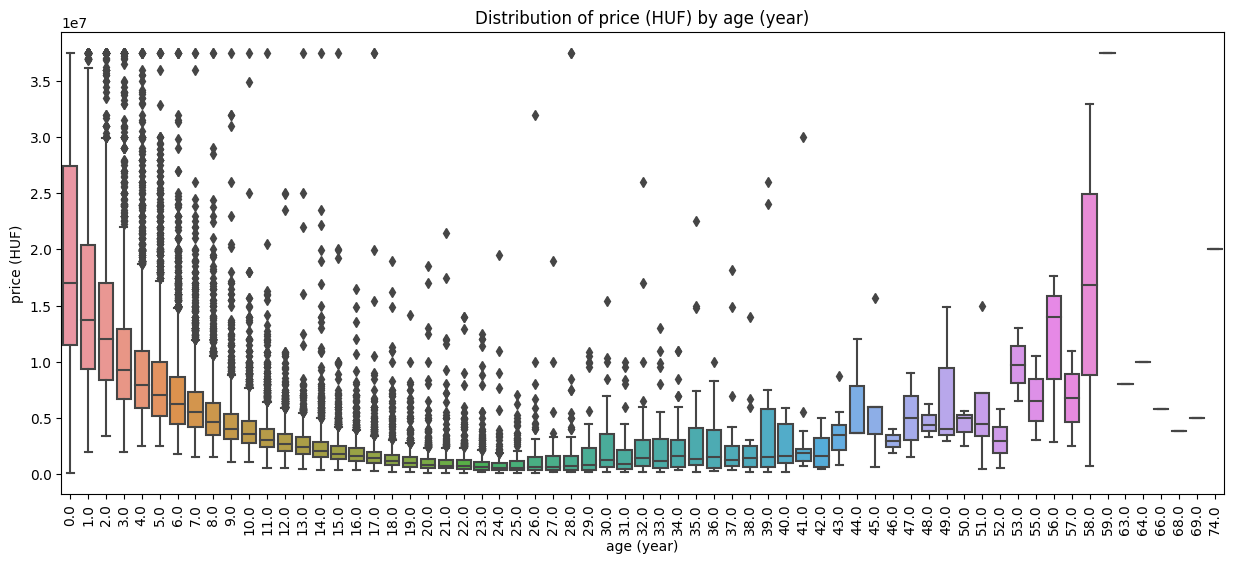

In [57]:
plot_price_by_column(df, 'age (year)')

In [78]:
def create_buckets(df, column_name, bucket_size):
    df = df.sort_values(column_name)
    
    # Check if the given column name exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Check if the column is numeric
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Column '{column_name}' must be numeric.")
        return

    # Define the bucketing function
    def bucket_value(value):
        lower_bound = (value // bucket_size) * bucket_size + 1
        upper_bound = lower_bound + bucket_size - 1
        return f"{int(lower_bound)}-{int(upper_bound)}"

    # Apply the bucketing function to the column and create a new column
    df[f'{column_name} buckets'] = df[column_name].apply(bucket_value)

    return df

# Usage example:
# df = create_buckets(df, 'column_name', 10)

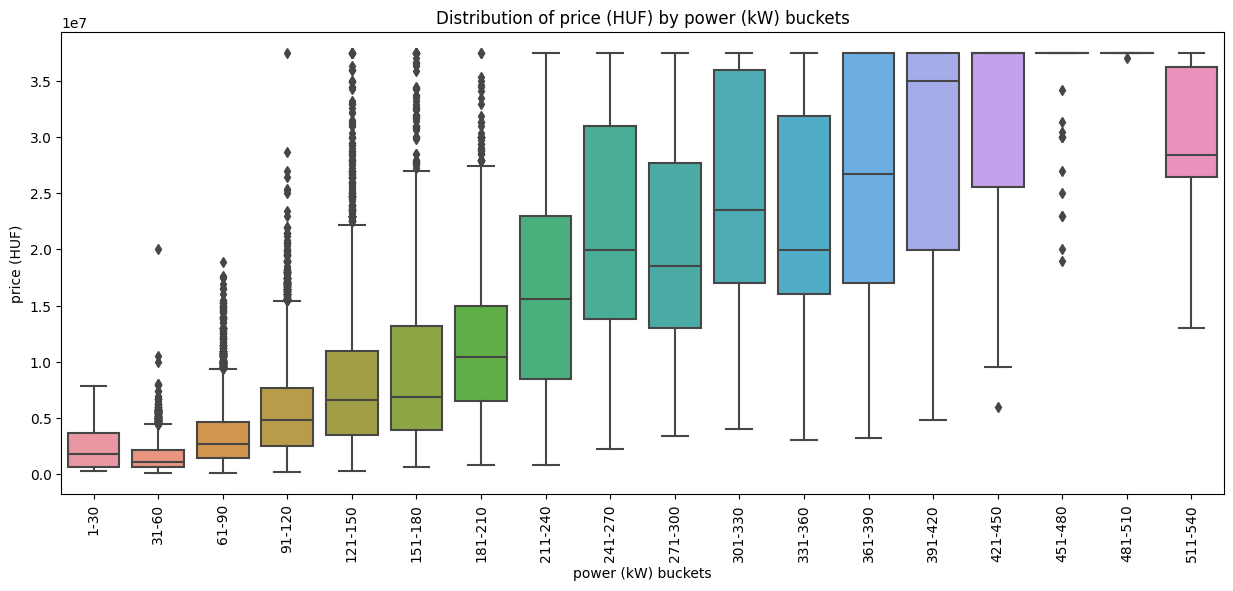

In [80]:
df_tmp_power = df[['price (HUF)', 'power (kW)']].copy()
df_tmp_power = create_buckets(df, 'power (kW)', 30)
plot_price_by_column(df_tmp_power, 'power (kW) buckets')

In [74]:
df[df['power (kW)'] == 1]

price (HUF) condition  \
link                                                                        
https://www.hasznaltauto.hu/szemelyauto/ac/egye...    2000000.0   Újszerű   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...    1999000.0   Újszerű   

                                                   design  financing  \
link                                                                   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...  Other      100.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...  Other      100.0   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              15000.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              15200.0   

                                                    shippable persons number  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/ac/egye...                       2.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...                       2.0   

                                                    number of doors  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              2.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              NaN   

                                                          color  \
link                                                              
https://www.hasznaltauto.hu/szemelyauto/ac/egye...       szürke   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...  sötétszürke   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/ac/egye...            300.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...            300.0   

                                                    total weight (kg)  ...  \
link                                                                   ...   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              550.0  ...   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              500.0  ...   

                                                    tfidf_buying tfidf_buys  \
link                                                                          
https://www.hasznaltauto.hu/szemelyauto/ac/egye...           0.0        0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...           0.0        0.0   

                                                   tfidf_end  tfidf_condition  \
link                                                                            
https://www.hasznaltauto.hu/szemelyauto/ac/egye...       0.0              0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...       0.0              0.0   

                                                    tfidf_adjustable  \
link                                                                   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...               0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...               0.0   

                                                   tfidf_price tfidf_inquire  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/ac/egye...         0.0           0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...         0.0           0.0   

                                                    tfidf_administration  \
link                                                                       
https://www.hasznaltauto.hu/szemelyauto/ac/egye...                   0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...                   0.0   

                                                    tfidf_seat  price log  
link                                           

In [58]:
useful_features = df_feature_importance[df_feature_importance.importance > 0.1]['feature'].values
len(useful_features)

40

In [59]:
df_corr = get_correlations(df_transformed[features])

In [43]:
df_tmp = df.drop(columns=['price (HUF)', 'price log'])
#df_tmp = df_tmp.fillna(df_tmp.median(numeric_only=True))
#df_tmp = df_tmp.fillna('missing')
#df_tmp = df_tmp.replace('', np.nan)


In [28]:
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

def pair_wise_modeling(df):
    results = []
    columns = df.columns
    
    all_cat_features = df.select_dtypes(include=['object']).columns
    for i in range(len(columns)):
        print(columns[i])
        for j in range(len(columns)):
            if columns[i] == columns[j]:
                continue
            
            # Not predict for nan
            msk = ~df[columns[j]].isna()
            X = df.loc[msk,[columns[i]]]
            y = df.loc[msk, columns[j]]
            
            if columns[i] in all_cat_features:
                cat_features = [columns[i]]
                X = X.fillna('missing')
            else:
                cat_features = None
                
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Check if the target is numerical or categorical
            if y.dtype == 'object':
                model = CatBoostClassifier(iterations=100, depth=4, learning_rate=0.1, 
                                           loss_function='MultiClass', early_stopping_rounds=10, 
                                           cat_features=cat_features)
                model.fit(X_train, y_train, verbose=False, eval_set=(X_test, y_test))
                pred = model.predict(X_test)
                score = f1_score(y_test, pred, average='macro')
                model_type = 'classification'
            else:
                model = CatBoostRegressor(iterations=100, depth=4, learning_rate=0.1, 
                                          loss_function='RMSE', early_stopping_rounds=10,
                                          cat_features=cat_features)
                model.fit(X_train, y_train, verbose=False, eval_set=(X_test, y_test))
                pred = model.predict(X_test)
                score = r2_score(y_test, pred)
                model_type = 'regression'
                
            results.append([columns[i], columns[j], score, model_type])
    return pd.DataFrame(results, columns=['variable1', 'variable2', 'score', 'model_type'])

In [30]:
base_score = {}
for col in categorical_features:
    msk = ~df[col].isna()
    y = df.loc[msk, col]
    max_value = y.value_counts().keys()[0]
    min_socre = f1_score(y, [max_value]*len(y), average='macro')
    base_score[col] = min_socre
    
base_score

{'condition': 0.09614703172615813,
 'design': 0.06317756362566826,
 'color': 0.04311988501363996,
 'type of climate': 0.11421540884372154,
 'fuel': 0.1631798282539148,
 'drive': 0.2690837484072744,
 'gearbox': 0.0507281546742567,
 'brand': 0.0545799886941775,
 'city': 0.43099052292298073}

In [183]:
"""
# Use the function
result_df = pair_wise_modeling(df_tmp)

result_df.reset_index(drop=True)
result_df.to_parquet('feature_realations_catboost.parquet')
"""
result_df = pd.read_parquet('feature_realations_catboost.parquet')
result_df.head()#"""

for k, v in base_score.items():
    result_df.loc[result_df.variable2 == k, 'score'] = (result_df.loc[result_df.variable2 == k, 'score'] - v) / (1-v)

In [184]:
df_corr_back = df_corr.copy()
df_corr_back.rename(columns={'variable1':'variable2', 'variable2':'variable1'}, inplace=True)


In [185]:
df_feature_relation = pd.merge(pd.concat([df_corr, df_corr_back]), result_df, on = ['variable1', 'variable2'], how='right')
df_feature_relation = pd.merge(df_feature_relation, df_feature_importance, left_on='variable1', right_on='feature', how='left')

df_tmp_realtion = df_feature_relation.copy()
df_tmp_realtion.rename(columns={'variable1': 'variable2', 'variable2': 'variable1'}, inplace=True)
df_feature_relation = pd.merge(
    df_feature_relation, 
    df_tmp_realtion[['variable1', 'variable2', 'score']],
    on = ['variable1', 'variable2']
)

varaible_pairs = df_feature_relation[['variable1', 'variable2']].values
varaible_pairs.sort(axis=1)
is_dublicated = pd.DataFrame(varaible_pairs).duplicated()

df_feature_relation = df_feature_relation[~is_dublicated]
df_feature_relation['score'] = df_feature_relation[['score_x', 'score_y']].max(axis=1)
df_feature_relation

variable1                 variable2  correlation   score_x  \
0                 condition                    design          NaN  0.033704   
1                 condition                 financing          NaN  0.015718   
2                 condition       clock position (km)          NaN  0.168422   
3                 condition  shippable persons number          NaN  0.000511   
4                 condition           number of doors          NaN  0.002744   
...                     ...                       ...          ...       ...   
85846           tfidf_price      tfidf_administration    -0.034500  0.008638   
85847           tfidf_price                tfidf_seat    -0.027704  0.011913   
86140         tfidf_inquire      tfidf_administration     0.007354  0.013925   
86141         tfidf_inquire                tfidf_seat    -0.044974  0.008267   
86435  tfidf_administration                tfidf_seat    -0.026553  0.024829   

           model_type               feature  importance  cumsum_importance  \
0      classification             condition    1.532662          82.567134   
1          regression             condition    1.532662          82.567134   
2          regression             condition    1.532662          82.567134   
3          regression             condition    1.532662          82.567134   
4          regression             condition    1.532662          82.567134   
...               ...                   ...         ...                ...   
85846      regression           tfidf_price    0.139846          91.343864   
85847      regression           tfidf_price    0.139846          91.343864   
86140      regression         tfidf_inquire    0.044659          97.038113   
86141      regression         tfidf_inquire    0.044659          97.038113   
86435      regression  tfidf_administration    0.031974          98.184395   

        score_y     score  
0      0.070598  0.070598  
1      0.062171  0.062171  
2      0.161611  0.168422  
3      0.036273  0.036273  
4      0.026454  0.026454  
...         ...       ...  
85846  0.006688  0.008638  
85847  0.001493  0.011913  
86140  0.009991  0.013925  
86141  0.005215  0.008267  
86435  0.004152  0.024829  

[43365 rows x 10 columns]

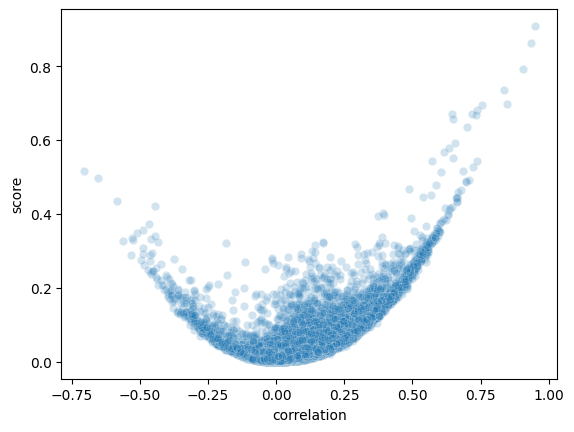

In [186]:
sns.scatterplot(data=df_feature_relation, x='correlation', y='score', alpha=0.2)
plt.show()

array([[<Axes: title={'center': 'correlation'}>]], dtype=object)

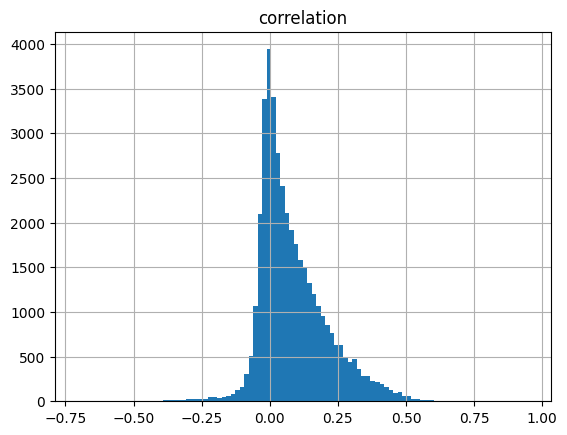

In [187]:
df_corr.hist('correlation', bins=100)

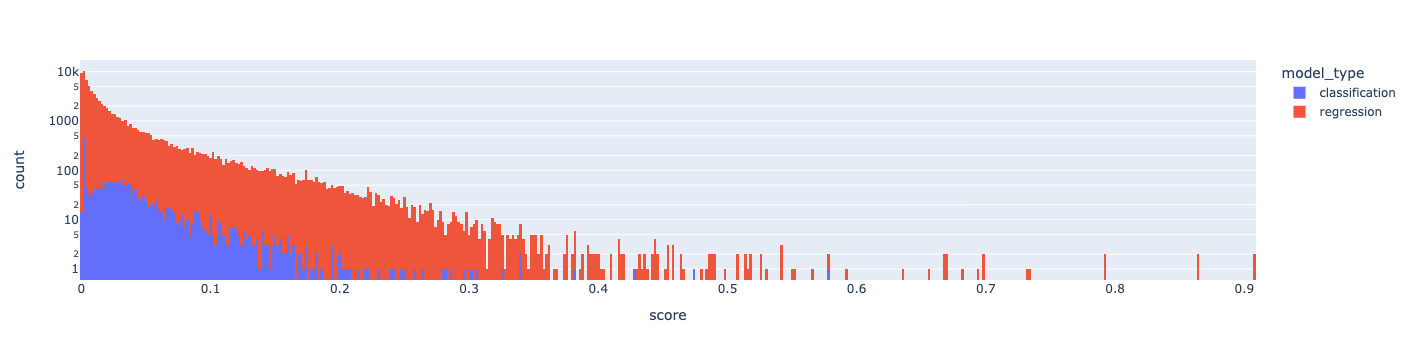

In [188]:
import plotly.express as px
px.histogram(result_df[result_df.score > 0], x='score', color='model_type', log_y=True,)


In [206]:
df_feature_relation2 = df_feature_relation.copy()
df_feature_relation2.sort_values('score', ascending=False, inplace=True)
df_feature_relation2 = df_feature_relation2[
    (df_feature_relation2.importance > 0.02) &
    (df_feature_relation2.score > 0.35)
]
df_feature_relation2

variable1  \
2065                        own weight (kg)   
5311                      summer tire width   
28922  electric seat adjustment driver side   
3540                cylinder capacity (cm3)   
2075                        own weight (kg)   
2369                      total weight (kg)   
3839                             power (kW)   
60823                 tfidf_making an offer   
3841                             power (kW)   
2070                        own weight (kg)   
2069                        own weight (kg)   
2364                      total weight (kg)   
3245                                   fuel   
2363                      total weight (kg)   
2077                        own weight (kg)   
23910                         keyless start   
3545                cylinder capacity (cm3)   
5605              summer tires aspect ratio   
2371                      total weight (kg)   
5310                      summer tire width   
7080                          driver airbag   
5062                          buy_from_shop   
1084                    clock position (km)   
3541                cylinder capacity (cm3)   
3547                cylinder capacity (cm3)   
8261                 predictable government   
1180               shippable persons number   
60800                 tfidf_making an offer   
28941  electric seat adjustment driver side   
4429                                gearbox   
3835                             power (kW)   
4427                                gearbox   
29799                   lane keeping system   
298                                  design   
3842                             power (kW)   
8267                 predictable government   
2071                        own weight (kg)   
61977                          tfidf_counts   
2072                        own weight (kg)   
62326                       tfidf_insurance   
29803                   lane keeping system   
16526                           rain sensor   
3248                                   fuel   
2961                        type of climate   
3432                                   fuel   
3932                             power (kW)   
3427                                   fuel   
2973                        type of climate   
3840                             power (kW)   
8567                            side airbag   
2365                      total weight (kg)   
69937                              tfidf_ad   
8271                 predictable government   
3836                             power (kW)   
15635                bluetooth speakerphone   
8262                 predictable government   

                                     variable2  correlation   score_x  \
2065                         total weight (kg)     0.948875  0.908940   
5311                 summer tires rim diameter     0.835657  0.734747   
28922  electric seat adjustment passenger side     0.845365  0.697473   
3540                                power (kW)     0.754134  0.667283   
2075                         summer tire width     0.735593  0.681444   
2369                         summer tire width     0.718652  0.670994   
3839                         summer tire width     0.645856  0.670862   
60823                       tfidf_it counts as     0.733864  0.483389   
3841                 summer tires rim diameter     0.648683  0.656194   
2070                                power (kW)     0.698883  0.518625   
2069                   cylinder capacity (cm3)     0.657622  0.507932   
2364                                power (kW)     0.632808  0.458717   
3245                   cylinder capacity (cm3)          NaN  0.071776   
2363                   cylinder capacity (cm3)     0.616370  0.454903   
2077                 summer tires rim diameter     0.648753  0.552179   
23910                     keyless entry system     0.738247  0.542570   
3545                         summer tire width     0.571350  0.542108   
5605                 summer tires rim di

In [207]:
import matplotlib

In [211]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from pyvis.network import Network

def create_interactive_graph_with_communities(df, df_feature_importance, relation_name='score', size_column='importance'):
    # Create a graph from the dataframe
    G_nx = nx.from_pandas_edgelist(df, 'variable1', 'variable2', edge_attr=relation_name)

    # Compute the best partition
    partition = community_louvain.best_partition(G_nx, weight='score', resolution=1)

    # Count number of unique communities
    num_communities = len(set(partition.values()))

    # Create a PyVis graph for visualization
    G_pyvis = Network(notebook=True)

    colormap = plt.get_cmap('viridis')

    # Add nodes with color and title based on their community
    for node, community in partition.items():
        color = matplotlib.colors.rgb2hex(colormap(community / num_communities))
        size = df_feature_importance[df_feature_importance['feature'] == node][size_column].values[0]  # get the size from the size_column
        G_pyvis.add_node(node, color=color, value=np.log(size+1), title=f"Importance: {round(size,2)}%")  # add value attribute to set node size and title for info

    # Add edges only within communities and with title
    for edge in G_nx.edges(data=True):
        if partition[edge[0]] == partition[edge[1]]:  # If nodes belong to the same community
            weight = round(edge[2][relation_name], 3)
            G_pyvis.add_edge(edge[0], edge[1], title=f"Predictive score: {weight}")

    # Transform partition into a list of communities
    communities = list(set(partition.values()))
    community_lists = [[node for node, community in partition.items() if community == c] for c in communities]

    return G_pyvis, community_lists




In [212]:
net = Network(notebook=True, cdn_resources='in_line')

In [213]:
G, communities = create_interactive_graph_with_communities(df_feature_relation2, df_feature_importance, size_column='importance')
G.show_buttons(filter_=['physics'])
G.show("graph.html")

graph.html


In [175]:
flattened_list = [item for sublist in communities for item in sublist]

single_communities = list(set(df_feature_importance['feature']) - set(flattened_list))
total_communities = communities.copy()
for x in single_communities:
    total_communities.append([x])
    
#total_communities

In [199]:
def get_most_important_features(communities, df_feature_importance, min_sum_ratio=0.8):
    most_important_features = []

    for community in communities:
        # Filter the features from this community
        community_feature_importances = df_feature_importance[df_feature_importance['feature'].isin(community)]

        # Sort the features in descending order of importance
        community_feature_importances = community_feature_importances.sort_values(by='importance', ascending=False)

        # Calculate the cumulative importance
        community_feature_importances['cumulative_importance'] = community_feature_importances['importance'].cumsum()

        # Select the most important features, up to 95% of the total importance
        sum_importance = community_feature_importances['importance'].sum()
        min_importance_sum = max(sum_importance * min_sum_ratio, community_feature_importances['cumulative_importance'].min())
        selected_features = community_feature_importances[
            community_feature_importances['cumulative_importance'] <= min_importance_sum
        ]['feature'].tolist()

        most_important_features.extend(selected_features)

    return most_important_features

# Use this function to get the most important features
important_features = get_most_important_features(communities, df_feature_importance)


In [200]:
max_features = 20
df_feature_importance_top_community=df_feature_importance.loc[
    df_feature_importance.feature.isin(important_features), :
].head(max_features)
df_feature_importance_top = df_feature_importance.head(max_features)

In [201]:
def selected_features_train(features):
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    categorical_features_selected = [x for x in categorical_features if x in features]
    model = regression_train(X_train_selected, X_test_selected, y_train, y_test, categorical_features_selected)
    
    test_predictions = model.predict(X_test_selected)
    return metrics.r2_score(y_test, test_predictions)

In [202]:
r2_results = []
for i in range(1, len(df_feature_importance_top)+1):
    features = df_feature_importance_top.head(i)['feature'].values
    r2 = selected_features_train(features)
    r2_results.append(r2)

0:	learn: 0.3574437	test: 0.3573802	best: 0.3573802 (0)	total: 6.37ms	remaining: 31.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1823002584
bestIteration = 419

Shrink model to first 420 iterations.
0:	learn: 0.3559339	test: 0.3556614	best: 0.3556614 (0)	total: 4.15ms	remaining: 20.8s
1000:	learn: 0.1017989	test: 0.1055630	best: 0.1055630 (1000)	total: 3.31s	remaining: 13.2s


KeyboardInterrupt: 

In [203]:
features_community = df_feature_importance_top_community['feature'].values
r2_community = selected_features_train(features_community)

features_top = df_feature_importance_top['feature'].values
r2_top = selected_features_train(features_top)

0:	learn: 0.3560131	test: 0.3557676	best: 0.3557676 (0)	total: 17.9ms	remaining: 1m 29s
1000:	learn: 0.0703310	test: 0.0787208	best: 0.0787208 (1000)	total: 10.3s	remaining: 41.1s
2000:	learn: 0.0659965	test: 0.0776318	best: 0.0776318 (2000)	total: 20.1s	remaining: 30.1s
3000:	learn: 0.0635448	test: 0.0770676	best: 0.0770665 (2996)	total: 29.9s	remaining: 19.9s
4000:	learn: 0.0616569	test: 0.0767594	best: 0.0767594 (4000)	total: 39.9s	remaining: 9.96s
4999:	learn: 0.0603372	test: 0.0765440	best: 0.0765429 (4985)	total: 49.9s	remaining: 0us

bestTest = 0.07654291787
bestIteration = 4985

Shrink model to first 4986 iterations.
0:	learn: 0.3560795	test: 0.3557966	best: 0.3557966 (0)	total: 10.3ms	remaining: 51.3s
1000:	learn: 0.0594962	test: 0.0678868	best: 0.0678868 (1000)	total: 11.9s	remaining: 47.7s
2000:	learn: 0.0541335	test: 0.0660241	best: 0.0660230 (1998)	total: 23.8s	remaining: 35.7s
3000:	learn: 0.0514358	test: 0.0653499	best: 0.0653499 (3000)	total: 35.7s	remaining: 23.8s
4000

In [179]:
r2_top_community

0.9358542048904865

In [180]:
r2_top

0.9544455487330908

In [204]:
set(features_community) - set(features_top)

{'automatically dimming interior mirror',
 'buy_from_shop',
 'curtain airbag',
 'electrically folding exterior mirrors',
 'electronic parking brake',
 'keyless start',
 'tfidf_electronic',
 'tfidf_window',
 'word_count'}

In [205]:
set(features_top) - set(features_community)

{'MOT is valid (days)',
 'clock position (km)',
 'condition',
 'summer tire width',
 'summer tires aspect ratio',
 'summer tires rim diameter',
 'total weight (kg)',
 'trunk (l)',
 'type of climate'}